
Keywords: time series, exploratory data analysis, fourier transform, 

# 1. Introduction





Founder of Bridgewater Associates Ray Dalio posits that the short-to-medium term fluctuations of the economy is fundamentally driven by cycles of credit and debt, while technology, population growth, nation's international position drives deeper, longer-term trends. When credit is readily available and growing, it fuels spending, asset prices rise, and the economy expands. When credit contracts, spending falls, asset prices decline, and the economy shrinks.

Project goal: identify historical debt cycles and current debt cycle stage.

# 2. Impact of consumption/credit
I will start by performing exploratory data analysis of three basic categories of debt in an economy based on the borrower: governments, corporations and households. 

I hypothesize a basic model of how debt and credit influces ecnomic fluctuations. In this model new consumer and government debt generates extra cash flows for corporations, leading to higher corporate earnings. On the other hand, when existing consumer and government debt becomes too high (measured by debt service ratio), spending is hurt leading to lower corporate earnings. 

In [1]:
from fredapi import Fred
import pandas_datareader.data as web
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Replace with your FRED API key
fred_api_key = '74b24ff9b1e5ffc59dc2ed559199b491'
fred = Fred(api_key=fred_api_key)

start_date = '2000-01-01'  # Approximately 50 years ago

# Get the data for each series

date_range = pd.date_range(start=start_date, end=pd.Timestamp.today(), freq="D")
df = pd.DataFrame(index=date_range)

# Consumer: non-mortgage consumer credit
df['Consumer_credit'] = fred.get_series('TOTALSL', observation_start=start_date) #SSAR
# Consumer: household debt-to-service ratio
df['Household_DSR'] = fred.get_series('TDSP', observation_start=start_date) #SSAR


# Government: total public debt
df['Federal_debt'] = fred.get_series('GFDEBTN', observation_start=start_date) #NSA
# Government: interest payment
df['Federal_interest'] = fred.get_series('A091RC1Q027SBEA', observation_start=start_date) #SSAR
# Government: GDP
df['Federal_GDP'] = fred.get_series('GDP', observation_start=start_date) #SSAR

# Corporations: NASDAQCOM
df['NASDAQCOM'] = fred.get_series('NASDAQCOM', observation_start=start_date) #NSR

df.head()

,Consumer_credit,Household_DSR,Federal_debt,Federal_interest,Federal_GDP,NASDAQCOM
2000-01-01,1538520.18,11.581974,5773392.0,354.822,10002.179,NaN
2000-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03,NaN,NaN,NaN,NaN,NaN,4131.15
2000-01-04,NaN,NaN,NaN,NaN,NaN,3901.69
2000-01-05,NaN,NaN,NaN,NaN,NaN,3877.54


In [2]:
df_M = df.resample('QE').mean()

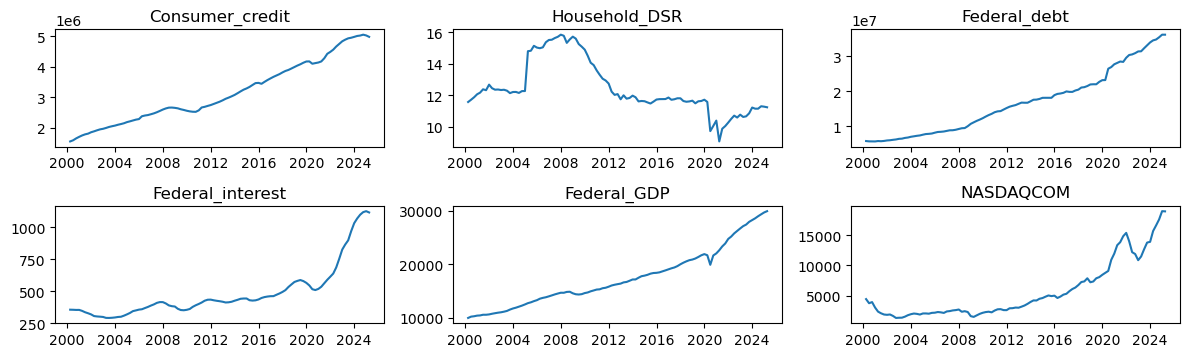

In [3]:
df_M.dropna(inplace=True)

fig, axes = plt.subplots(2, 3, figsize=(12, 4))

for i, column in enumerate(df_M.columns):
    axes[i//3, i % 3].plot(df_M.index, df_M[column])
    axes[i//3, i % 3].set_title(column)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlap
plt.show()

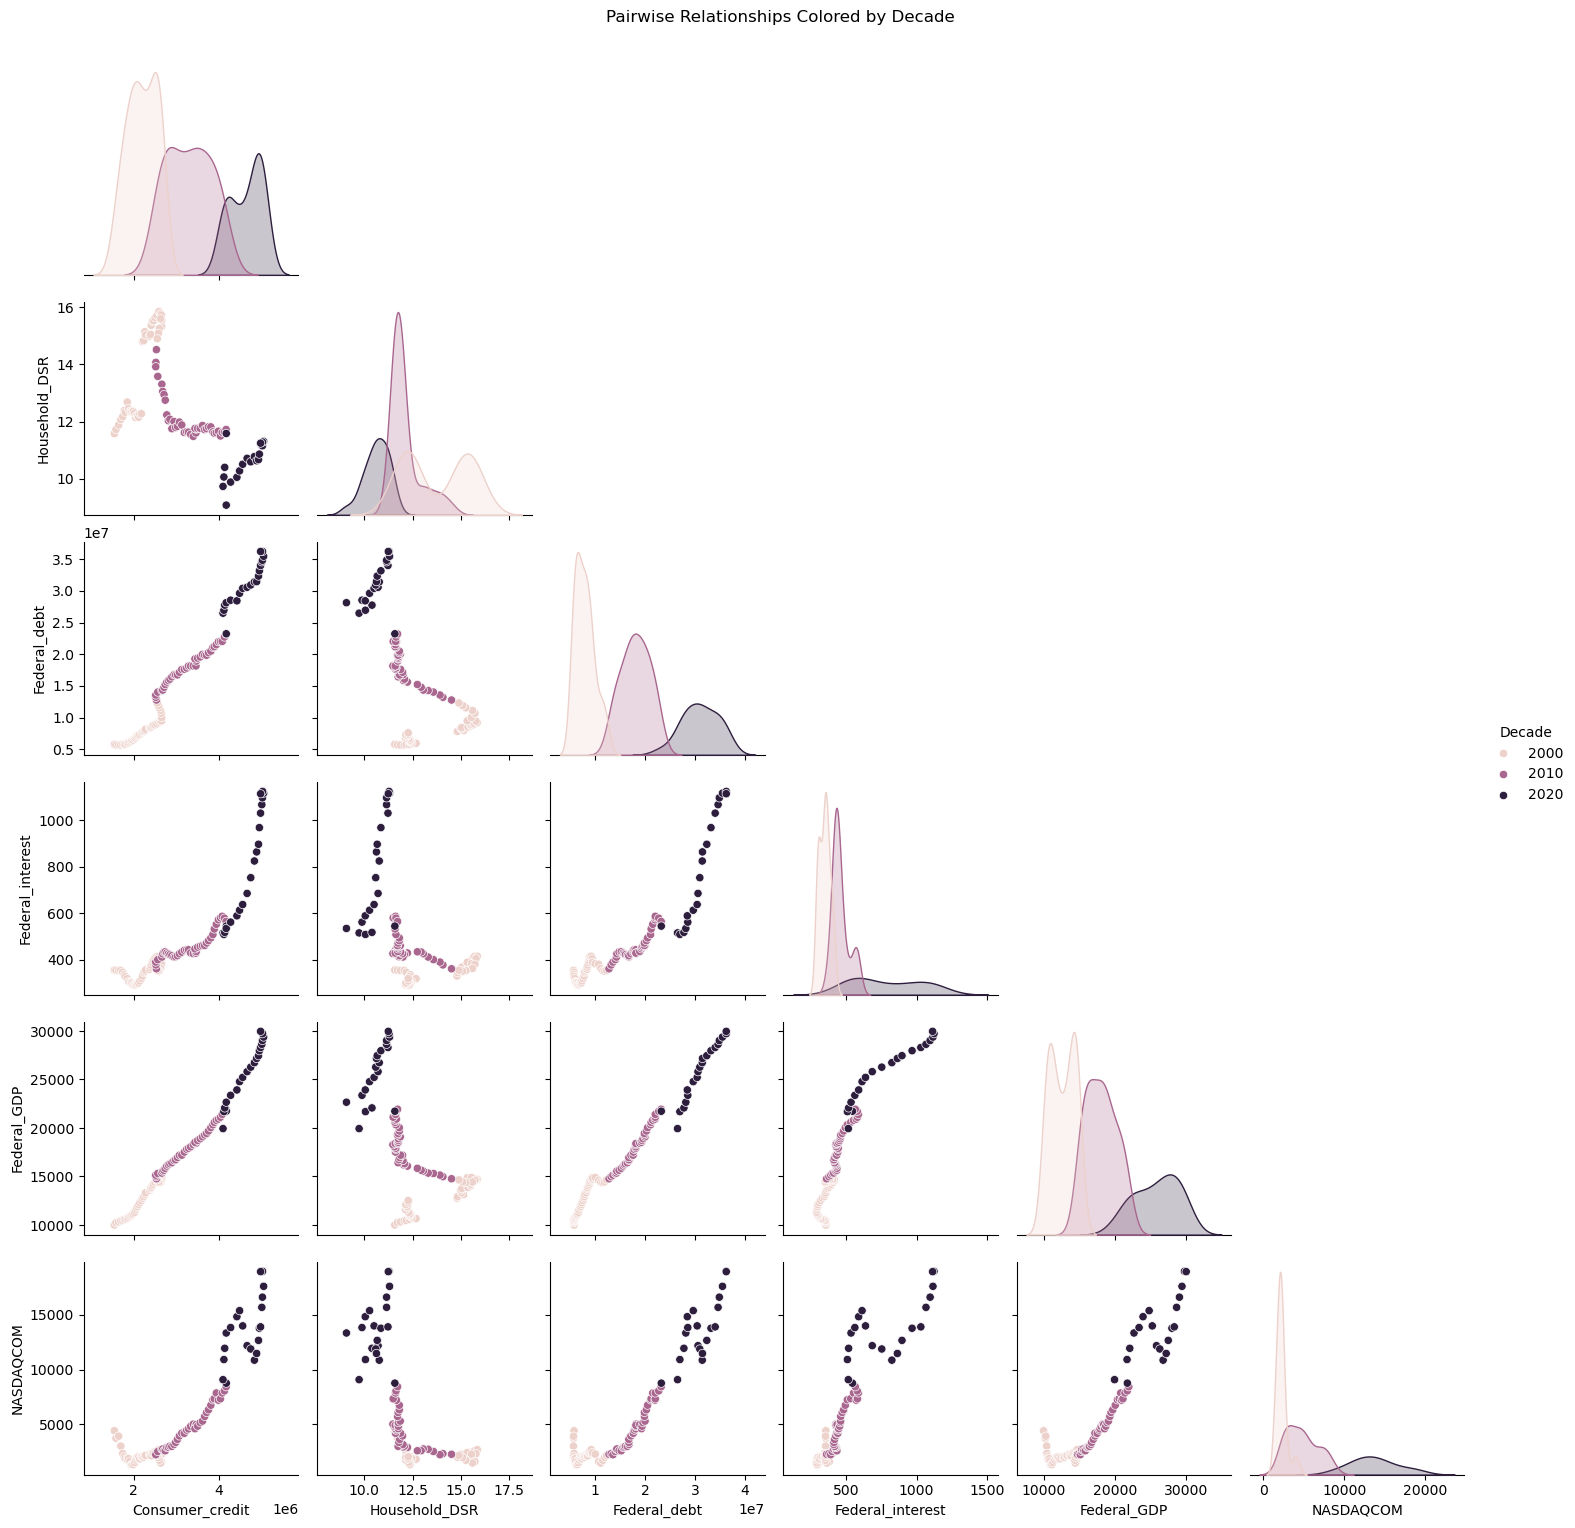

In [4]:

# Add a decade label to the index (which contains dates)
df_M['Decade'] = (df_M.index.year // 10) * 10

# Create the pairplot with hue based on Decade
sns.pairplot(df_M, hue='Decade', diag_kind='kde', corner=True)
plt.suptitle('Pairwise Relationships Colored by Decade', y=1.02)
plt.show()


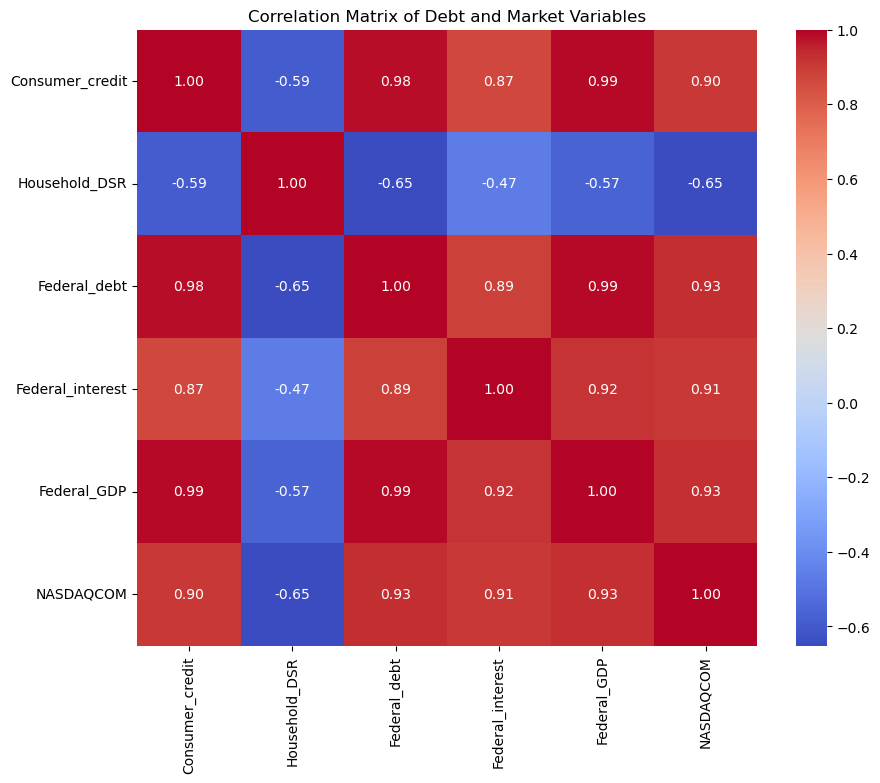

In [5]:
# Compute correlation matrix
corr_matrix = df_M.drop(columns='Decade').corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Debt and Market Variables")
plt.show()



conclusion....

If we focuse on the overall stock market performance, federal GDP and federal spending have the best correlations (0.93), consumer credit and federal interests are second (0.91), while house hold DSR has a negative correlation (-0.65).

# 3.Impact of supply-side economy on the stock market
So far, I have only considered credit-related macroeconomic factors that influence aggregate demand. Conversely, operational costs impact the supply side of corporate earnings.

For prices I choose Sticky Price Consumer Price Index less Food and Energy from FRED. The index represents the incorporate expectations about future inflation to a greater degree than prices that change on a more frequent basis


In [3]:
dfs = pd.DataFrame(index=date_range)

# Sticky Price Consumer Price Index
dfs['CPI'] = fred.get_series('CORESTICKM159SFRBATL', observation_start=start_date) 

# Producer Price Index by Commodity: All Commodities (PPIACO)
dfs['PPI'] = fred.get_series('PPIACO', observation_start=start_date) 

# Average Hourly Earnings of Production and Nonsupervisory Employees, Total Private (AHETPI)
dfs['Wage'] = fred.get_series('AHETPI', observation_start=start_date) 

# Nonfarm Business Sector: Labor Productivity (Output per Hour) for All Workers (OPHNFB)
dfs['Productivity'] = fred.get_series('OPHNFB', observation_start=start_date) 

# ICE BofA BBB US Corporate Index Option-Adjusted Spread (BAMLC0A4CBBB)
dfs['CreditSpread'] = fred.get_series('BAMLC0A4CBBB', observation_start=start_date) 


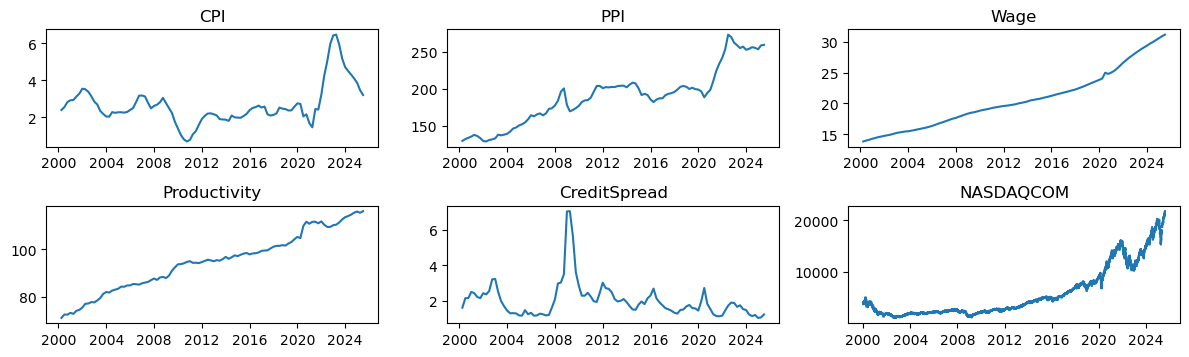

In [4]:
# %matplotlib notebook

# %matplotlib widget

dfs_M = dfs.resample('QE').mean()
dfs_M.dropna(inplace=True)

fig, axes = plt.subplots(2, 3, figsize=(12, 4))

for i, column in enumerate(dfs_M.columns):
    axes[i//3, i % 3].plot(dfs_M.index, dfs_M[column])
    axes[i//3, i % 3].set_title(column)

axes[1, 2].plot(df.index, df['NASDAQCOM'])
axes[1, 2].set_title(df['NASDAQCOM'].name)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlap
plt.show()

**Credit spreads and stock index are highly correlated. When credit spreads are widening (positive slope in borrowing costs), the stock market is often falling (negative slope in stock performance).**

In essence, credit spreads and stock performance are two sides of the same coin when it comes to market sentiment and the outlook for corporate health and the broader economy. They tend to move in opposite directions, meaning if one is trending up, the other is often trending down.

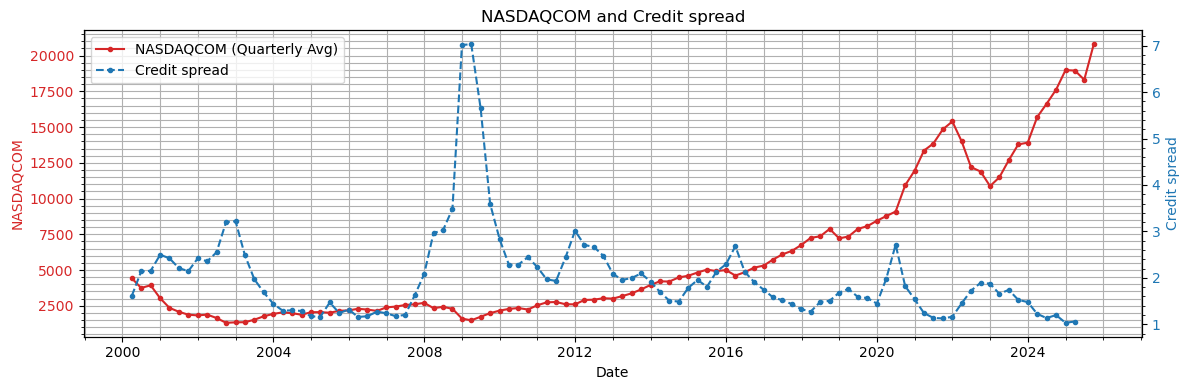

In [10]:
fig, ax1 = plt.subplots(figsize=(12, 4)) # ax1 is now an Axes object
plt.minorticks_on()
# 2. Plot on the first y-axis
ax1.plot(df['NASDAQCOM'].resample('QE').mean(), label='NASDAQCOM (Quarterly Avg)', color='tab:red', marker='.')
ax1.set_ylabel('NASDAQCOM', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_xlabel('Date')
ax1.set_title('NASDAQCOM and Credit spread') # Title usually goes on the figure or primary axis

# 3. Create a twin Axes for the second y-axis
ax2 = ax1.twinx() # This creates a new Axes object ax2 that shares x-axis with ax1

# 4. Plot on the second y-axis
ax2.plot(dfs_M['CreditSpread'], label='Credit spread', color='tab:blue', linestyle='--', marker='.')
ax2.set_ylabel('Credit spread', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Add legends for both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Improve layout
fig.tight_layout()
plt.minorticks_on() 
ax1.grid(True, which='both')
plt.show()

# 4. Modeling next four years stock market performance using historical economic data
Four year fits with average debt cycle of 3-5 years. Four year is also the election cycle in the United States, which affects adjustments of economic policy. 

# 1) Data preparation


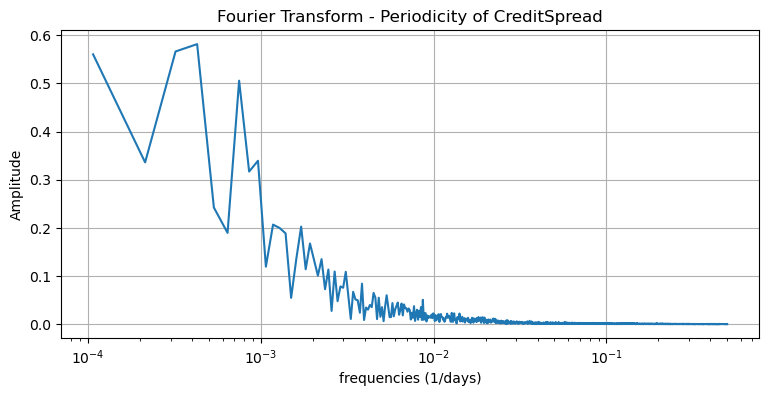

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Interpolate to fill weekends and holidays
credit_spread_interpolated = dfs['CreditSpread'].interpolate(method='linear')
credit_spread_clean  = credit_spread_interpolated.dropna()
# Perform the Fast Fourier Transform (FFT)
N = len(credit_spread_clean)
yf = np.fft.fft(credit_spread_clean.values)
xf = np.fft.fftfreq(N, 1)

# Amplitude Spectrum
plt.figure(figsize=(9, 4))
frequencies = xf[1:N//2]
amplitudes = 2.0/N * np.abs(yf[1:N//2])
periods = 1 / frequencies
plt.plot(frequencies, amplitudes)
plt.xlabel('frequencies (1/days)')  # Updated label
plt.xscale('log')
plt.ylabel('Amplitude')
plt.title('Fourier Transform - Periodicity of CreditSpread') # Updated title
plt.grid(True)
plt.show()

In [25]:
dfs['CreditSpread'].describe()

count    6687.000000
mean        1.996269
std         1.019431
min         0.970000
25%         1.340000
50%         1.770000
75%         2.290000
max         8.040000
Name: CreditSpread, dtype: float64

In [4]:
# [MXDL-11-06] 10.transformer(train).py
# Transformer code: https://github.com/suyash/transformer
# The original transformer code above is for natural language 
# processing. I modified it slightly for use in time series 
# forecasting.
#
# This code was used in the deep learning online 
# course provided by www.youtube.com/@meanxai.
#
# A detailed description of this code can be found at
# https://youtu.be/KkfAvhmpznM
#
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import pickle
# from transformer import Encoder, Decoder
# from transformer import PaddingMask, PaddingAndLookaheadMask

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load a pre-trained encoder-decoder model like T5
tokenizer = AutoTokenizer.from_pretrained("t5-small")
model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

# Read dataset
# with open('dataset.pkl', 'rb') as f:
#  	_, xi_enc, xi_dec, xp_dec = pickle.load(f)

f = df_M['NASDAQCOM']

n_tstep = xi_enc.shape[1]  # 50
n_feat = xi_enc.shape[2]   # 2
d_model = 100

# Encoder
EmbDense = Dense(d_model, use_bias=False)
i_enc = Input(batch_shape=(None, n_tstep, n_feat))
h_enc = EmbDense(i_enc)
padding_mask = PaddingMask()(h_enc)
encoder = Encoder(num_layers = 1, 
                  d_model = d_model, 
                  num_heads = 5, 
                  d_ff = 64, 
                  dropout_rate=0.5)
o_enc, _ = encoder(h_enc, padding_mask)

# Decoder
i_dec = Input(batch_shape=(None, n_tstep, n_feat))
h_dec = EmbDense(i_dec)
lookahead_mask = PaddingAndLookaheadMask()(h_dec)
decoder = Decoder(num_layers = 1, 
                  d_model = d_model, 
                  num_heads = 5, 
                  d_ff = 64,
                  dropout_rate=0.5)
o_dec, _, _ = decoder(h_dec, o_enc, lookahead_mask, padding_mask)
y_dec = Dense(n_feat)(o_dec)
model = Model(inputs=[i_enc, i_dec], outputs=y_dec)
model.compile(loss='mse', 
              optimizer=optimizers.Adam(learning_rate=0.001))

# Training: teacher forcing
hist = model.fit([xi_enc, xi_dec], xp_dec, 
                 epochs=100,
                 batch_size = 200)

# Save the trained model
model.save("models/transformer.h5")

# Visually see the loss history
plt.plot(hist.history['loss'], label='Train loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

C:\Users\pzh07\miniconda3\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\pzh07\miniconda3\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\pzh07\miniconda3\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/resource_handle.proto. Please update the gencode to avoid compatibility violations i

ModuleNotFoundError: No module named 'transformer'